In [1]:
from datetime import timedelta, datetime
import os
import glob
import calendar

import matplotlib.pyplot as plt
import random
import pickle
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity

def seed_all(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

In [2]:
# implement SMOTER
def sigmoid(x):
    return 1 / (1 +np.exp(-x))

def relevance(x):
    x = np.array(x)    
    return sigmoid(x)

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = int(o / 100) # the number of new cases to generate
    for index, case in tqdm(D.iterrows(), total=D.shape[0]):
    # for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}          
            for a in D.columns:
                # skip target column
                if a == target:
                    continue
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            # new_cases = new_cases.append(attr, ignore_index = True)
            new_cases = pd.concat([new_cases, pd.DataFrame([attr])], ignore_index=True)
    
    return new_cases

def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]  

    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
    
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D

### 데이터 전처리

In [3]:
SEED = 0

seed_all(SEED)

in_path = './MES_data/'
out_path = './New_data/'

time_pattern = r'(\d{4})(\d{1,2})(\d{1,2})'
hour_pattern = r'(\d{1,2}):(\d{1,2}):(\d{1,2})'

whole_df = pd.DataFrame()
file_ls = [file for file in os.listdir(in_path) if file.endswith(".xlsx")]
for fileNm in tqdm(file_ls):
    tmp_df = pd.read_excel(in_path+fileNm)
    tmp_df = tmp_df[tmp_df.columns[:18]]    
    tmp_df.columns = [colNm.split('|')[-1].replace('(℃)','').replace('(kg)','') for colNm in tmp_df.columns]
    tmp_df.dropna(subset=['출탕량','출탕시간','홀딩로투입시간'], inplace=True)
    
    tmp_df = tmp_df[tmp_df['Charge'].str.contains('\d{2}')]
    tmp_df['Date'] = fileNm.split('_')[-1].split('.')[0]
    tmp_df[['year', 'month', 'day']] = tmp_df['Date'].str.extract(time_pattern)
    tmp_df[['출탕_hour', '출탕_minute', '출탕_sec']] = tmp_df['출탕시간'].str.extract(hour_pattern)
    tmp_df[['투입_hour', '투입_minute', '투입_sec']] = tmp_df['홀딩로투입시간'].str.extract(hour_pattern)
    
    whole_df = pd.concat([whole_df, tmp_df], ignore_index=True)

whole_df[['Charge','year','month','day','출탕_hour','출탕_minute','출탕_sec','투입_hour','투입_minute','투입_sec']] = whole_df[['Charge','year','month','day','출탕_hour','출탕_minute','출탕_sec','투입_hour','투입_minute','투입_sec']].apply(pd.to_numeric)
whole_df['출탕시간'] = whole_df['Date'] + ' ' + whole_df['출탕시간']
whole_df['홀딩로투입시간'] = whole_df['Date'] + ' ' + whole_df['홀딩로투입시간']

# convert datetime into seconds
whole_df['출탕시간'] = whole_df['출탕시간'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True)).apply(lambda x: x.timestamp())
whole_df['홀딩로투입시간'] = whole_df['홀딩로투입시간'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True)).apply(lambda x: x.timestamp())
# 시간차 계산 다시
whole_df['출탕투입시간차'] = whole_df['투입_minute'] - whole_df['출탕_minute']
whole_df['출탕투입시간차'] = [round(abs(minute_gap)) if minute_gap > 0 else round(abs(60 + minute_gap)) for minute_gap in whole_df['출탕투입시간차']]

categorical_features = list(whole_df.dtypes[whole_df.dtypes == "object"].index)
remove_features = categorical_features + ['수정', '호기']
# removed_df = whole_df[remove_features]

whole_df.drop(columns=remove_features, inplace=True)
whole_df = whole_df.fillna(0)
whole_df.drop_duplicates(inplace=True)
print(whole_df.shape)
whole_df.head()

100%|██████████| 40/40 [00:00<00:00, 40.11it/s]


(1193, 26)


,Charge,출탕량,출탕시간,홀딩로투입시간,실질홀딩로투입온도,실질홀딩로온도,Metal Temp Set,Metal Temp,연주냉각 前 냉각수온도,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,w.kg,mm/min,V%W,V%B,year,month,day,출탕_hour,출탕_minute,출탕_sec,투입_hour,투입_minute,투입_sec,출탕투입시간차
0,1,1125.0,1.654594e+09,1.654595e+09,1329.0,0.0,1055.0,1038.0,36.0,51.0,46.0,26.1,203.0,88.0,60.0,60.0,2022,6,7,9,31,0,9,41,0,10
1,2,1015.0,1.654596e+09,1.654596e+09,1328.0,0.0,1253.0,1045.0,36.0,62.0,60.0,6.5,1136.0,420.0,60.0,60.0,2022,6,7,9,58,0,10,7,0,9
2,3,1092.0,1.654597e+09,1.654598e+09,1325.0,0.0,1050.0,1044.0,38.0,65.0,60.0,5.5,2447.0,540.0,60.0,60.0,2022,6,7,10,21,0,10,33,0,12
3,4,1105.0,1.654599e+09,1.654599e+09,1324.0,0.0,1050.0,1044.0,40.0,66.0,60.0,5.5,3682.0,540.0,60.0,60.0,2022,6,7,10,47,0,10,55,0,8
4,5,1116.0,1.654600e+09,1.654601e+09,1320.0,0.0,1050.0,1045.0,41.0,66.0,60.0,5.5,4858.0,540.0,60.0,60.0,2022,6,7,11,9,0,11,18,0,9


### 전처리 데이터 저장

1193


<Axes: >

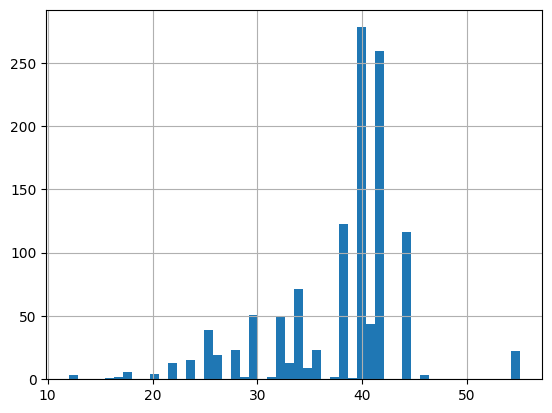

In [4]:
tar_col = '연주냉각 前 냉각수온도'
print(len(whole_df))
whole_df[tar_col].hist(bins=50)

### 데이터 증강

100%|██████████| 471/471 [00:14<00:00, 33.16it/s]


3828ea at the 1th iteration


100%|██████████| 1710/1710 [00:59<00:00, 28.85it/s]


19831ea at the 2th iteration


100%|██████████| 9635/9635 [08:42<00:00, 18.44it/s]


126846ea at the 3th iteration


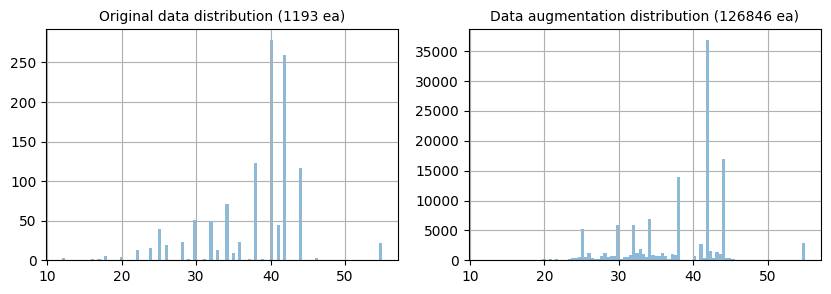

,Charge,출탕량,출탕시간,홀딩로투입시간,실질홀딩로투입온도,실질홀딩로온도,Metal Temp Set,Metal Temp,연주냉각 前 냉각수온도,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,w.kg,mm/min,V%W,V%B,year,month,day,출탕_hour,출탕_minute,출탕_sec,투입_hour,투입_minute,투입_sec,출탕투입시간차
count,1193.000000,1193.000000,1193,1193,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.0,1193.0,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.0,1193.000000,1193.000000,1193.0,1193.000000
mean,15.751886,1095.366303,2023-02-08 08:52:30.377200384,2023-02-08 09:03:32.992455936,1279.010897,70.418273,983.590109,979.861693,37.953060,63.880134,59.380553,6.009975,12729.819782,538.699078,60.0,60.0,2022.600168,6.566639,16.046940,14.506287,29.069573,0.0,14.682313,29.551551,0.0,10.037720
min,1.000000,500.000000,2022-06-07 09:31:00,2022-06-07 09:41:00,0.000000,0.000000,0.000000,0.000000,12.000000,23.000000,14.000000,4.800000,0.000000,0.000000,60.0,60.0,2022.000000,1.000000,1.000000,8.000000,0.000000,0.0,9.000000,0.000000,0.0,1.000000
25%,8.000000,1100.000000,2022-10-24 20:34:00,2022-10-24 20:41:00,1323.000000,0.000000,947.000000,944.000000,34.000000,64.000000,60.000000,5.000000,3563.000000,540.000000,60.0,60.0,2022.000000,5.000000,8.000000,12.000000,14.000000,0.0,12.000000,14.000000,0.0,9.000000
50%,16.000000,1105.000000,2023-02-07 14:11:00,2023-02-07 14:20:00,1325.000000,0.000000,981.000000,978.000000,40.000000,65.000000,60.000000,5.200000,8730.000000,540.000000,60.0,60.0,2023.000000,6.000000,16.000000,14.000000,29.000000,0.0,15.000000,30.000000,0.0,10.000000
75%,23.000000,1110.000000,2023-05-25 19:51:00,2023-05-25 20:02:00,1327.000000,0.000000,1060.000000,1055.000000,42.000000,66.000000,60.000000,5.500000,21975.000000,600.000000,60.0,60.0,2023.000000,10.000000,25.000000,17.000000,44.000000,0.0,18.000000,45.000000,0.0,11.000000
max,33.000000,1326.000000,2023-11-02 21:03:00,2023-11-02 21:08:00,1425.000000,1273.000000,1253.000000,1198.000000,55.000000,69.000000,60.000000,26.100000,62344.000000,600.000000,60.0,60.0,2023.000000,12.000000,30.000000,21.000000,59.000000,0.0,21.000000,59.000000,0.0,59.000000
std,8.768870,66.421479,NaN,NaN,241.441735,288.932757,120.088630,122.893602,6.364579,5.386088,3.554375,3.649636,11322.155915,98.506119,0.0,0.0,0.490069,3.357221,8.693001,3.352877,17.327269,0.0,3.349421,17.330170,0.0,3.884803


,Charge,출탕량,출탕시간,홀딩로투입시간,실질홀딩로투입온도,실질홀딩로온도,Metal Temp Set,Metal Temp,연주냉각 前 냉각수온도,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,w.kg,mm/min,V%W,V%B,year,month,day,출탕_hour,출탕_minute,출탕_sec,투입_hour,투입_minute,투입_sec,출탕투입시간차,max_day
count,126846.000000,126846.000000,126846,126846,126846.000000,126846.0,126846.000000,126846.000000,126846.000000,126846.000000,126846.000000,126846.000000,126846.000000,126846.000000,126846.0,126846.0,126846.000000,126846.000000,126846.000000,126846.000000,126846.000000,126846.0,126846.000000,126846.000000,126846.0,126846.000000,126846.000000
mean,15.404317,1103.327224,2023-02-20 20:48:26.954732800,2023-02-20 21:51:31.155574528,1323.870512,0.0,989.455899,987.976444,37.923214,65.222656,59.999653,5.095387,10851.030565,575.107879,60.0,60.0,2022.500780,6.204981,15.967157,14.561594,24.784495,0.0,14.641234,27.157459,0.0,9.479842,30.239842
min,0.000000,273.000000,2021-09-28 12:27:00,2021-09-28 12:39:00,0.000000,0.0,0.000000,0.000000,12.000000,6.000000,40.000000,0.000000,4.000000,60.000000,60.0,60.0,2022.000000,1.000000,1.000000,0.000000,0.000000,0.0,3.000000,0.000000,0.0,0.000000,28.000000
25%,9.000000,1100.000000,2022-12-01 14:41:00,2022-12-01 15:02:00,1321.000000,0.0,950.000000,948.000000,33.000000,65.000000,60.000000,4.800000,4554.000000,540.000000,60.0,60.0,2022.000000,4.000000,8.000000,12.000000,10.000000,0.0,12.000000,12.000000,0.0,8.000000,30.000000
50%,16.000000,1105.000000,2023-02-09 16:36:00,2023-02-09 17:13:00,1325.000000,0.0,981.000000,980.000000,41.000000,66.000000,60.000000,5.000000,7116.000000,600.000000,60.0,60.0,2023.000000,6.000000,17.000000,15.000000,22.000000,0.0,15.000000,26.000000,0.0,10.000000,31.000000
75%,21.000000,1112.000000,2023-05-25 19:29:00,2023-05-25 20:00:00,1328.000000,0.0,1065.000000,1062.000000,42.000000,66.000000,60.000000,5.500000,18186.000000,600.000000,60.0,60.0,2023.000000,9.000000,25.000000,17.000000,38.000000,0.0,17.000000,42.000000,0.0,11.000000,31.000000
max,31.000000,1175.000000,2023-09-25 20:38:00,2023-09-25 21:33:00,1380.000000,0.0,1177.000000,1168.000000,55.000000,71.000000,60.000000,6.300000,31031.000000,664.000000,60.0,60.0,2023.000000,12.000000,31.000000,20.000000,59.000000,0.0,20.000000,59.000000,0.0,15.000000,31.000000
std,7.281298,32.884340,NaN,NaN,16.254624,0.0,87.667616,84.680741,6.641862,3.069544,0.079811,0.493711,8786.930015,43.083651,0.0,0.0,0.500001,3.356136,8.508554,2.869254,17.300007,0.0,2.845239,16.726037,0.0,2.651161,1.002422


<Figure size 640x480 with 0 Axes>

In [5]:
def remove_max_outliers_IQR(df, col, sen=1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    return df[(df[col] <= (q3+sen*IQR))]

def remove_max_outliers_sigma(df, col, sen=3): # 3시그마 이상치 제거
    # lower_limit = df[col].mean() - (df[col].std()*sen)
    upper_limit = df[col].mean() + (df[col].std()*sen)
    return df[(df[col] <= upper_limit)]

seed_all(SEED)

# --------------------------------------
#    Data Augmentation by Oversampling
# --------------------------------------
old_df = whole_df.copy()
new_nor_df = old_df.copy()

thres = 0.5
overRtio = 1000
underRtio = 100
k_num = 5

data_num = 90000

iter = 1
while len(new_nor_df) < data_num:
    seed_all(SEED)

    tmp_df = SmoteR(new_nor_df, target=tar_col, th=thres, o=overRtio, u=underRtio, k=k_num, categorical_col=[])
    new_nor_df = pd.concat([new_nor_df, tmp_df], ignore_index=True)
    # 중복 제거    
    new_nor_df.drop_duplicates(ignore_index=True, inplace=True)

    # 출탕 투입시간 비교
    new_nor_df = new_nor_df[new_nor_df['출탕시간'] <= new_nor_df['홀딩로투입시간']]

    # 날짜 범위 체크 + 정수형으로 변경 및 마이너스 부호 제거
    new_nor_df['year'] = np.random.choice(old_df['year'].unique().astype('int').tolist(), len(new_nor_df))
    new_nor_df['month'] = new_nor_df['month'].round().abs()
    new_nor_df['day'] = new_nor_df['day'].round().abs()
    new_nor_df = new_nor_df[(new_nor_df['month'] >= 1)&(new_nor_df['month'] <= 12)]

    # 시간 범위 체크 + 정수형으로 변경 및 마이너스 부호 제거
    for time_col in ['출탕_hour', '출탕_minute', '출탕_sec', '투입_hour', '투입_minute', '투입_sec']:
        new_nor_df[time_col] = new_nor_df[time_col].round().abs()

    new_nor_df = new_nor_df[(new_nor_df['출탕_hour'] >= 0)&(new_nor_df['출탕_hour'] <= 23)]
    new_nor_df = new_nor_df[(new_nor_df['출탕_minute'] >= 0)&(new_nor_df['출탕_minute'] < 60)]
    new_nor_df = new_nor_df[(new_nor_df['출탕_sec'] >= 0)&(new_nor_df['출탕_sec'] < 60)]

    new_nor_df = new_nor_df[(new_nor_df['투입_hour'] >= 0)&(new_nor_df['투입_hour'] <= 23)]
    new_nor_df = new_nor_df[(new_nor_df['투입_minute'] >= 0)&(new_nor_df['투입_minute'] < 60)]
    new_nor_df = new_nor_df[(new_nor_df['투입_sec'] >= 0)&(new_nor_df['투입_sec'] < 60)]

    new_nor_df['max_day'] = new_nor_df.apply(lambda x: calendar.monthrange(int(x['year']), int(x['month']))[1], axis=1)
    new_nor_df = new_nor_df[new_nor_df['day'] <= new_nor_df['max_day']]

    # 음수 제거 및 IQR 기반 아웃라이어 제거
    for col in new_nor_df.columns:
        new_nor_df = new_nor_df[new_nor_df[col] >= 0]
        if col != tar_col and new_nor_df[col].nunique() != 1:
            new_nor_df = remove_max_outliers_sigma(new_nor_df, col, 2)

    # Nan 값 제거 
    new_nor_df.dropna()
    new_nor_df.reset_index(drop=True, inplace=True)    
    print(f'{len(new_nor_df)}ea at the {iter}th iteration')
    iter += 1

fig = plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,2,1)
ax.set_title(f'Original data distribution ({len(old_df)} ea)', size = 10)
old_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
ax=fig.add_subplot(1,2,2)
ax.set_title(f'Data augmentation distribution ({len(new_nor_df)} ea)', size = 10)
new_nor_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
plt.show()
plt.clf()

# convert seconds into datetime
old_df['출탕시간'] = old_df['출탕시간'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')).apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
old_df['홀딩로투입시간'] = old_df['홀딩로투입시간'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')).apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
new_nor_df['출탕시간'] = new_nor_df['출탕시간'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')).apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
new_nor_df['홀딩로투입시간'] = new_nor_df['홀딩로투입시간'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')).apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))

display(old_df.describe())
display(new_nor_df.describe())

### 후처리

In [8]:
seed_all(SEED)

old_df['type'] = 'Original'
new_nor_df['type'] = 'Normal'

# 병합
new_data_df = pd.concat([new_nor_df, old_df], ignore_index=True)
# 중복 제거
new_data_df.drop_duplicates(inplace=True)

# 차지 정수형 변경 및 문자열로 표현
new_data_df['Charge'] = new_data_df['Charge'].apply(lambda x: f'{int(x):02d}')
# 날짜 복원
new_data_df['Date'] = new_data_df['출탕시간'].apply(lambda x: x.strftime('%Y-%m-%d'))
# 호기 추가
new_data_df['호기'] = 2
# ID 추가
new_data_df['ID'] = new_data_df['Date'].str.replace('-','') + '_' + new_data_df['Charge']

ordered_cols = ['type', 'ID', 'Date', '호기', 
                'Charge', '출탕량', '출탕시간', '홀딩로투입시간', '출탕투입시간차', 
                '실질홀딩로투입온도', 'Metal Temp Set', 'Metal Temp', 
                '연주냉각 前 냉각수온도', '연주냉각 後 냉각수온도', 'WITHDROW', 'Waiting Time', 'w.kg', 'mm/min', 'V%W', 'V%B',
                'year', 'month', 'day', '출탕_hour', '출탕_minute', '출탕_sec', '투입_hour', '투입_minute', '투입_sec'
                ]

new_data_df = new_data_df[ordered_cols]
# data shuffling하고 index reset
new_data_df = new_data_df.sample(frac=1).reset_index(drop=True)

new_data_df.to_csv(f'./New_Data/MES_data_argumentation_{len(new_data_df)}ea_from_{len(old_df)}ea.csv', index=False, encoding="utf-8-sig")
print('원본 및 증강 데이터 결과 :', new_data_df.shape)
display(new_data_df.head())

original_df = new_data_df[new_data_df['type']=='Original'].reset_index(drop=True)
original_df.to_csv('./New_Data/Merged_original_dataset.csv', index=False, encoding="utf-8-sig")
print('원본 전처리 데이터 결과 :', original_df.shape)
display(original_df.head())

원본 및 증강 데이터 결과 : (126233, 29)


,type,ID,Date,호기,Charge,출탕량,출탕시간,홀딩로투입시간,출탕투입시간차,실질홀딩로투입온도,Metal Temp Set,Metal Temp,연주냉각 前 냉각수온도,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,w.kg,mm/min,V%W,V%B,year,month,day,출탕_hour,출탕_minute,출탕_sec,투입_hour,투입_minute,투입_sec
0,Normal,20220811_24,2022-08-11,2,24,1101.0,2022-08-11 16:56:00,2022-08-11 17:32:00,6.0,1343.0,829.0,826.0,42.0,63.0,60.0,6.0,28154.0,540.0,60.0,60.0,2023,8.0,11.0,18.0,2.0,0.0,19.0,20.0,0.0
1,Normal,20220919_23,2022-09-19,2,23,1162.0,2022-09-19 16:46:00,2022-09-19 17:38:00,10.0,1333.0,810.0,807.0,55.0,65.0,60.0,5.5,26270.0,660.0,60.0,60.0,2023,9.0,19.0,17.0,10.0,0.0,16.0,38.0,0.0
2,Normal,20230626_29,2023-06-26,2,29,1108.0,2023-06-26 19:30:00,2023-06-26 19:40:00,10.0,1320.0,1009.0,1009.0,38.0,64.0,60.0,4.8,149.0,600.0,60.0,60.0,2022,6.0,26.0,19.0,29.0,0.0,19.0,40.0,0.0
3,Normal,20221201_04,2022-12-01,2,04,1117.0,2022-12-01 10:41:00,2022-12-01 11:29:00,7.0,1326.0,972.0,995.0,23.5,67.0,60.0,4.6,3769.0,600.0,60.0,60.0,2023,12.0,1.0,10.0,24.0,0.0,11.0,29.0,0.0
4,Normal,20230619_10,2023-06-19,2,10,1104.0,2023-06-19 13:33:00,2023-06-19 13:39:00,12.0,1283.0,980.0,979.0,44.0,65.0,60.0,5.5,2378.0,540.0,60.0,60.0,2022,6.0,19.0,14.0,26.0,0.0,18.0,21.0,0.0


원본 전처리 데이터 결과 : (1193, 29)


,type,ID,Date,호기,Charge,출탕량,출탕시간,홀딩로투입시간,출탕투입시간차,실질홀딩로투입온도,Metal Temp Set,Metal Temp,연주냉각 前 냉각수온도,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,w.kg,mm/min,V%W,V%B,year,month,day,출탕_hour,출탕_minute,출탕_sec,투입_hour,투입_minute,투입_sec
0,Original,20230216_13,2023-02-16,2,13,1101.0,2023-02-16 13:56:00,2023-02-16 14:05:00,9.0,1324.0,986.0,983.0,40.0,68.0,60.0,4.8,15027.0,600.0,60.0,60.0,2023,2.0,16.0,13.0,56.0,0.0,14.0,5.0,0.0
1,Original,20220607_06,2022-06-07,2,06,1100.0,2022-06-07 11:33:00,2022-06-07 11:43:00,10.0,1330.0,1055.0,1049.0,41.0,66.0,60.0,5.5,6206.0,540.0,60.0,60.0,2022,6.0,7.0,11.0,33.0,0.0,11.0,43.0,0.0
2,Original,20230504_32,2023-05-04,2,32,710.0,2023-05-04 20:31:00,2023-05-04 20:52:00,21.0,0.0,1000.0,991.0,38.0,54.0,60.0,5.0,35992.0,600.0,60.0,60.0,2023,5.0,4.0,20.0,31.0,0.0,20.0,52.0,0.0
3,Original,20221121_13,2022-11-21,2,13,1100.0,2022-11-21 13:30:00,2022-11-21 13:37:00,7.0,1323.0,969.0,966.0,38.0,68.0,60.0,4.8,14978.0,600.0,60.0,60.0,2022,11.0,21.0,13.0,30.0,0.0,13.0,37.0,0.0
4,Original,20230519_18,2023-05-19,2,18,1103.0,2023-05-19 15:46:00,2023-05-19 15:57:00,11.0,1325.0,1098.0,1098.0,42.0,66.0,60.0,5.0,161.0,600.0,60.0,60.0,2023,5.0,19.0,15.0,46.0,0.0,15.0,57.0,0.0


In [7]:
display(original_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   type            1193 non-null   object        
 1   ID              1193 non-null   object        
 2   Date            1193 non-null   object        
 3   호기              1193 non-null   int64         
 4   Charge          1193 non-null   object        
 5   출탕량             1193 non-null   float64       
 6   출탕시간            1193 non-null   datetime64[ns]
 7   홀딩로투입시간         1193 non-null   datetime64[ns]
 8   출탕투입시간차         1193 non-null   float64       
 9   실질홀딩로투입온도       1193 non-null   float64       
 10  실질홀딩로온도         1193 non-null   float64       
 11  Metal Temp Set  1193 non-null   float64       
 12  Metal Temp      1193 non-null   float64       
 13  연주냉각 前 냉각수온도    1193 non-null   float64       
 14  연주냉각 後 냉각수온도    1193 non-null   float64       
 15  WITH

None